In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'dataset/train.csv')

# Define a dictionary to map 'diagnosis' values to binary classification types
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}
# Define a dictionary to map 'diagnosis' values to categorical types
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# Add a new column 'binary_type' to the DataFrame, which maps 'diagnosis' values to binary classification types
df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)

# Add a new column 'type' to the DataFrame, which maps 'diagnosis' values to categorical types
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
# Show the first five rows of the DataFrame, including the new columns 'binary_type' and 'type'
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

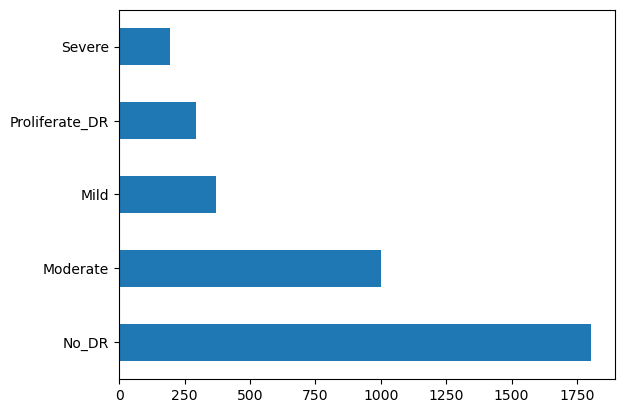

In [3]:
# Generate a horizontal bar chart of the counts of each unique value in the 'type' column
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

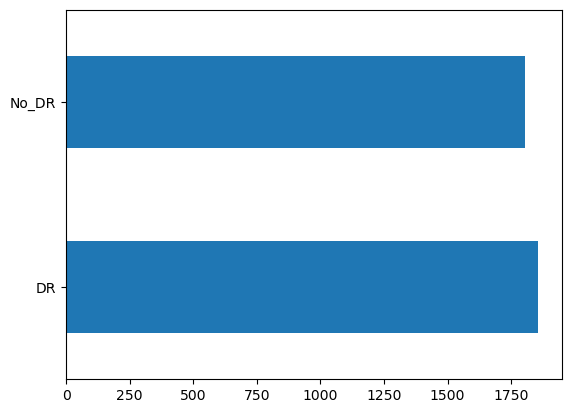

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified(arranged in layers) train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
#os.path.join() function is used to create the paths to the directories regardless of the operating system.
#shutil - provides many functions of high-level operations      rmtree = delete
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = r'dataset\gaussian_filtered_images\gaussian_filtered_images'
for index, row in train.iterrows():
    # Extract the diagnosis, binary diagnosis, and id code values from the current row
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    # Create the paths to the source and destination files
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    # Create the destination directory if it does not exist
    os.makedirs(dstfile, exist_ok = True)
    # Copy the image from the source file path to the destination file path
    shutil.copy(srcfile, dstfile)

    #Iterate over the rows in the validation dataframe and perform the same operations as in the train loop
for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
#This code copies the images from the source directory to their respective 
#folders in the train, validation, and test 
#directories based on the binary diagnosis of each image.

#this code prepares the data for use in the model training phase by splitting the images into train, validation, and test
#sets and organizing them based on their binary diagnosis.

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'
#the generators that will be used for loading the images
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)
#we are using the rescale argument to scale the pixel values of the images between 0 and 1, which is a common preprocessing step for deep learning models

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [9]:
# Building the model


#The first layer with 8 filters learns basic low-level features like edges, gradients, and curves.
#The second layer with 16 filters learns more complex features like shapes and textures.
#The third layer with 32 filters learns even more complex and abstract features like objects and patterns.

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])


#model.compile() - Compiles the model and configures the training process.
#optimizer=tf.keras.optimizers.Adam(lr = 1e-5) - Sets the optimizer to Adam with a learning rate of 1e-5.
#loss=tf.keras.losses.BinaryCrossentropy() - Sets the loss function to binary cross


model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

#model.fit(train_batches, ...) trains the model on the training data.
#epochs=30 specifies that the model should be trained for 30 epochs (i.e., 30 passes over 
#the entire training dataset).
#validation_data=val_batches specifies the validation dataset on which the model's performance is evaluated after each epoch.

Epoch 1/30



81/81 [==============================] - 13s 143ms/step - loss: 0.4286 - acc: 0.8884 - val_loss: 0.5935 - val_acc: 0.8600
Epoch 2/30
81/81 [==============================] - 10s 117ms/step - loss: 0.1790 - acc: 0.9208 - val_loss: 0.4816 - val_acc: 0.6982
Epoch 3/30
81/81 [==============================] - 9s 115ms/step - loss: 0.1299 - acc: 0.9520 - val_loss: 0.4252 - val_acc: 0.8073
Epoch 4/30
81/81 [==============================] - 9s 110ms/step - loss: 0.0738 - acc: 0.9711 - val_loss: 0.4343 - val_acc: 0.7564
Epoch 5/30
81/81 [==============================] - 9s 115ms/step - loss: 0.0472 - acc: 0.9828 - val_loss: 0.4149 - val_acc: 0.8582
Epoch 6/30
81/81 [==============================] - 9s 114ms/step - loss: 0.0299 - acc: 0.9891 - val_loss: 0.1415 - val_acc: 0.9564
Epoch 7/30
81/81 [==============================] - 9s 114ms/step - loss: 0.0223 - acc: 0.9910 - val_loss: 0.2342 - val_acc: 0.9418
Epoch 8/30
81/81 [==============================] - 9s 117ms/step - loss: 0.0253 - ac

In [10]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [11]:

loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


C:\Users\Samarth Sharma\AppData\Local\Temp\ipykernel_13564\4023278290.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 1s 63ms/step - loss: 3.3191 - acc: 0.7400
Accuracy:  0.7400000095367432


In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class(path):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    
    # Create a subplot to display input image and prediction result
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(RGBImg)
    ax[0].axis('off')
    
    # Preprocess the image
    image = np.array(RGBImg) / 255.0
    
    # Load the saved model
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    
    # Predict the class of the input image
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)
    
    if per == 1:
        prediction = 'No DR'
    else:
        prediction = 'DR'
    
    # Display prediction result above the image
    ax[1].text(0.5, 0.5, prediction, fontsize=12, ha='center', va='center')
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 98ms/step


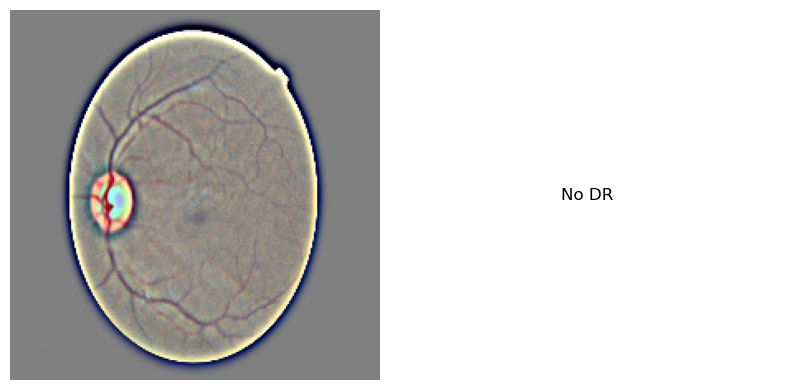

In [13]:
predict_class('dataset/gaussian_filtered_images/gaussian_filtered_images/No_DR/0cb6b898389f.png')

In [18]:
 predict_class('dataset/gaussian_filtered_images/gaussian_filtered_images/Severe/d7ab5c040294.png')


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


1/1 [==============================] - 0s 78ms/step


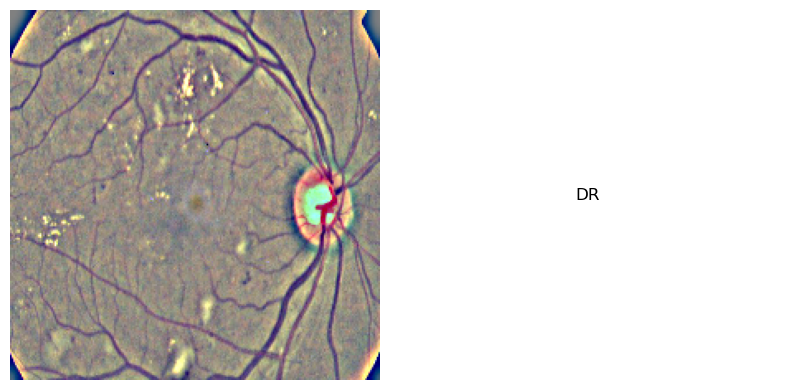

In [15]:
predict_class('dataset/gaussian_filtered_images/gaussian_filtered_images/Moderate/3a122851e526.png')

1/1 [==============================] - 0s 76ms/step


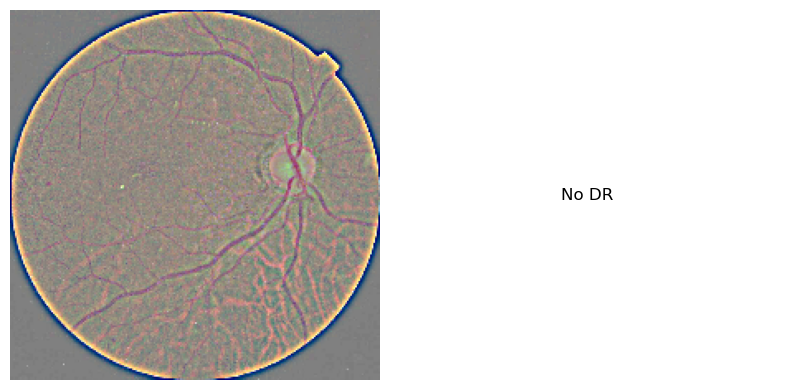

In [16]:
predict_class('dataset/gaussian_filtered_images/gaussian_filtered_images/Mild/4cae247d9909.png')